# Import libraries

In [1]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
import glob
#!pip install openpyxl

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import h5py
import re

from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.Timer import Timer
from lhcsmapi.metadata.MappingMetadata import MappingMetadata
from scipy import signal
import xarray as xr

from src.utils.utils import log_acquisition
from src.utils.hdf_tools import acquisition_to_hdf5, load_from_hdf_with_regex
from src.visualisation.sec_quench_visualisation import plot_wiggle_analysis
from src.modeling.sec_quench import *
from src.utils.dataset_utils import *
from src.utils.utils import interp

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')
#%matplotlib widget
#%matplotlib inline
#%load_ext autoreload

# Define Paths

In [3]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / 'backup/20220707_data'
simulation_path = file_path / 'backup/20220707_simulation'

# Read the (clean) MP3 file

In [4]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
len(mp3_fpa_df)

3981

# Select events to analyze

In [5]:
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['timestamp_fgc', 'Circuit Name'])
lower_limit = Time.to_unix_timestamp('2014-01-01 00:00:00+01:00')
mp3_fpa_df_period = mp3_fpa_df_unique[mp3_fpa_df_unique['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 

mp3_fpa_df_period_all = mp3_fpa_df[mp3_fpa_df['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 
print(len(mp3_fpa_df_period), len(mp3_fpa_df_period_all))

822 3981


In [6]:
# Add information, whether download was successfull
df_acquisition = pd.read_excel("../data/20220707_acquisition_summary.xlsx")
mp3_fpa_df_period_merged = mp3_fpa_df_period.merge(df_acquisition , left_on=['Circuit Name', 'timestamp_fgc'], right_on=['Circuit Name', 'timestamp_fgc'], how="left")
df_to_analyze = mp3_fpa_df_period_merged[mp3_fpa_df_period_merged['VoltageNQPS.*U_DIODE']==1]
len(df_to_analyze)

563

# Analyze all events

In [ ]:
fpa_identifier = "RB_RB.A78_1636740012620000000"    
circuit_name = fpa_identifier.split("_")[1]
timestamp_fgc = int(fpa_identifier.split("_")[2])

mp3_fpa_df_subset = mp3_fpa_df[(mp3_fpa_df.timestamp_fgc == timestamp_fgc) & 
                               (mp3_fpa_df['Circuit Name'] == circuit_name)]

In [ ]:
all_quenched_magnets = mp3_fpa_df_subset.Position.values
quench_times = mp3_fpa_df_subset["Delta_t(iQPS-PIC)"].values /1e3
        
# load data
data_dir = data_path / (fpa_identifier + ".hdf5")
data = load_from_hdf_with_regex(file_path=data_dir, regex_list=['VoltageNQPS.*U_DIODE'])
df_data = u_diode_data_to_df(data, len_data=len(data[0]))

# load simulation 
simulation_dir = simulation_path / (fpa_identifier + ".hdf")
data_sim = load_from_hdf_with_regex(file_path=simulation_dir, regex_list=["0v_magf"])
df_sim = u_diode_simulation_to_df(data_sim, circuit_name=circuit_name)

# save magnet order for later useage
magnet_list=df_sim.columns
                        
# drop quenched magnet
max_time = df_data.index.max()
df_data_noq = drop_quenched_magnets(df_data, all_quenched_magnets, quench_times, max_time)
df_sim_noq = drop_quenched_magnets(df_sim, all_quenched_magnets, quench_times, max_time)

# sometimes only noise is stored, mean must be in windwo -1, -10
df_data_noq = df_data_noq.drop(df_data_noq.columns[~(-1>df_data_noq.mean()) & (-10<df_data_noq.mean())], axis=1)

# align 
t_first_extraction = min(float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000, 
                         float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000)
t_first_extraction = get_u_diode_data_alignment_timestamps(df_sim_noq)
df_data_aligned = align_u_diode_data(df_data_noq.copy(), t_first_extraction)

# cut out time frame to analyze, [-0.25, 1] is 1336 samples
time_frame = [-0.25, 1]
df_data_cut = df_data_aligned[(time_frame[0] <= df_data_aligned.index) & (time_frame[1] >= df_data_aligned.index)]

# adjust simulation length to data 
df_sim_noq_resampled = interp(df_sim_noq, df_data_cut.index)

# add quenched magnets again for continuity
dropped_columns_data = magnet_list[~magnet_list.isin(df_data_cut.columns)]
dropped_columns_simulation = magnet_list[~magnet_list.isin(df_sim_noq_resampled.columns)]
df_data_cut[dropped_columns_data] = np.nan
df_sim_noq_resampled[dropped_columns_simulation] = np.nan
# bring into electrical order again
df_data_cut = df_data_cut[magnet_list]
df_sim_noq_resampled = df_sim_noq_resampled[magnet_list]


In [ ]:
df_data_cut.plot(legend=False) 

In [ ]:
df_data_cut.plot(legend=False) 
ee_odd = float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000
ee_even = float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000

plt.axvline(x=ee_odd)
plt.axvline(x=ee_even)

In [ ]:
df_sim_noq_resampled.plot(legend=False) 
ee_odd = float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000
ee_even = float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000

plt.axvline(x=ee_odd)
plt.axvline(x=ee_even)

# Get all events

In [7]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


from src.dataset import load_dataset
from src.datasets.rb_fpa_prim_quench_ee_plateau import RBFPAPrimQuenchEEPlateau
from src.datasets.rb_fpa_full_quench import RBFPAFullQuench

/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details a

In [8]:
dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_udiode")
plot_dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_udiode_plots")

context_path = Path("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
acquisition_summary_path = Path("../data/20220707_acquisition_summary.xlsx")
data_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_data")
simulation_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_simulation")
metadata_path = Path("../data/RB_metadata.csv")

In [9]:
ds = RBFPAFullQuench(dataset_path=dataset_path,
             context_path=context_path,
             metadata_path=metadata_path,
             data_path=data_path,
             simulation_path=simulation_path,
             acquisition_summary_path=acquisition_summary_path,
             plot_dataset_path=plot_dataset_path)

fpa_identifiers = ds.select_events()

dataset = ds.load_dataset(fpa_identifiers=fpa_identifiers, 
                          dataset_path=dataset_path, 
                          drop_data_vars=['simulation','el_position_feature','event_feature'],
                          location={'time': slice(0.25, 0.55)})

In [10]:
mp3_fpa_df_in_dataset = mp3_fpa_df_period[mp3_fpa_df_period.fpa_identifier.isin(dataset.event.values)]
mp3_fpa_df_in_dataset["first_exrtraction"] = [min(float(row['Delta_t(EE_odd-PIC)']) / 1000, float(row['Delta_t(EE_even-PIC)']) / 1000) for i, row in mp3_fpa_df_in_dataset.iterrows()]

RB_RB.A78_1615210747420000000
RB_RB.A78_1615271973700000000
RB_RB.A78_1615308663520000000
RB_RB.A78_1615363402260000000


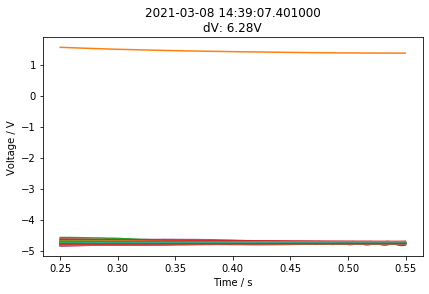

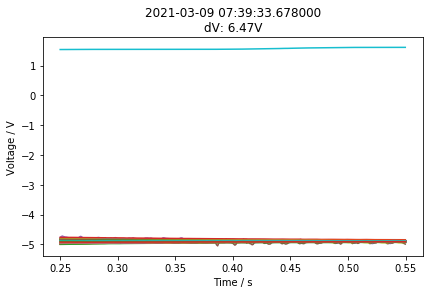

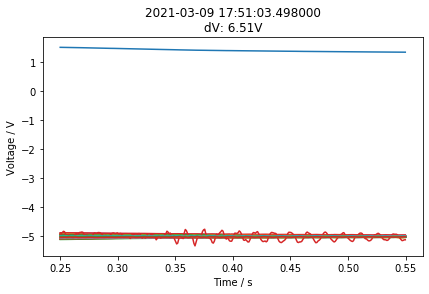

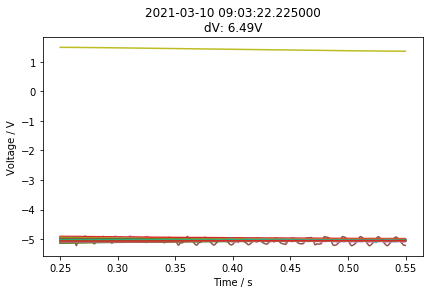

In [11]:
i = 0
max_deviation = np.zeros(len(mp3_fpa_df_in_dataset))
for k, row in mp3_fpa_df_in_dataset.iterrows():

    d = dataset['data'].loc[{'event': row['fpa_identifier']}]#, 'time':slice(t_ee1 + window[0],t_ee1+ window[1])}]
  
    max_deviation[i] = max(abs(d.min() - d.mean()), abs(d.max() - d.mean())).values
    
    if max_deviation[i] > 1.5:
        plt.figure()
        plt.title(f"{row['Timestamp_PIC']}\ndV: {max_deviation[i]:.2f}V")
        plt.tight_layout()
        plt.xlabel('Time / s')
        plt.ylabel('Voltage / V')
        print(row['fpa_identifier'])
        plt.plot(d.time.values, d.values.T)
        
    i+=1
    if i>3:
        break

# old

In [12]:
dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_dataset")
plot_dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_plots")

context_path = Path("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
acquisition_summary_path = Path("../data/20220707_acquisition_summary.xlsx")
data_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_data")
simulation_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_simulation")
metadata_path = Path("../data/RB_metadata.csv")

In [13]:
ds = RBFPAPrimQuenchEEPlateau(dataset_path=dataset_path,
             context_path=context_path,
             metadata_path=metadata_path,
             data_path=data_path,
             simulation_path=simulation_path,
             acquisition_summary_path=acquisition_summary_path,
             plot_dataset_path=plot_dataset_path)

fpa_identifiers = ds.select_events()

dataset = ds.load_dataset(fpa_identifiers=fpa_identifiers, 
                          dataset_path=dataset_path, 
                          drop_data_vars=['simulation','el_position_feature','event_feature'])

In [14]:
mp3_fpa_df_in_dataset = mp3_fpa_df_period[mp3_fpa_df_period.fpa_identifier.isin(dataset.event.values)]
mp3_fpa_df_in_dataset["first_exrtraction"] = [min(float(row['Delta_t(EE_odd-PIC)']) / 1000, float(row['Delta_t(EE_even-PIC)']) / 1000) for i, row in mp3_fpa_df_in_dataset.iterrows()]

RB_RB.A12_1620503728760000000
RB_RB.A45_1621314674500000000
RB_RB.A45_1621873352060000000


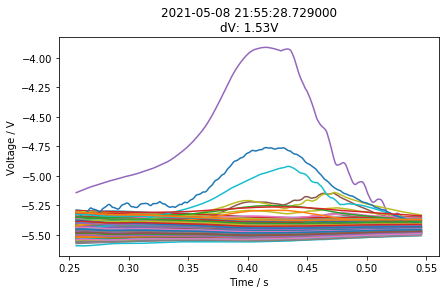

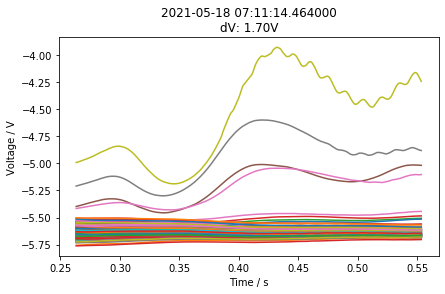

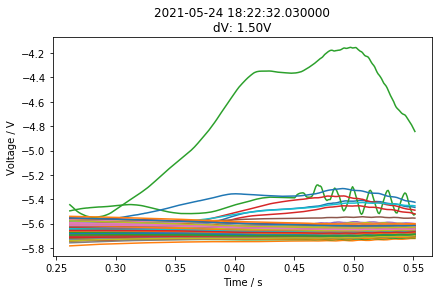

In [17]:
i = 0
max_deviation = np.zeros(len(mp3_fpa_df_in_dataset))
for k, row in mp3_fpa_df_in_dataset.iterrows():

    d = dataset['data'].loc[{'event': row['fpa_identifier']}]#, 'time':slice(t_ee1 + window[0],t_ee1+ window[1])}]
    d = pd.DataFrame(d.values.T, index=d.time.values).rolling(20).mean()
  
    max_deviation[i] = max(abs(d.min().min() - d.mean().mean()), abs(d.max().max() - d.mean().mean()))
    
    if max_deviation[i] > 1.5:
        plt.figure()
        plt.title(f"{row['Timestamp_PIC']}\ndV: {max_deviation[i]:.2f}V")
        plt.tight_layout()
        plt.xlabel('Time / s')
        plt.ylabel('Voltage / V')
        print(row['fpa_identifier'])
        plt.plot(d.index.values, d.values)
        
    i+=1

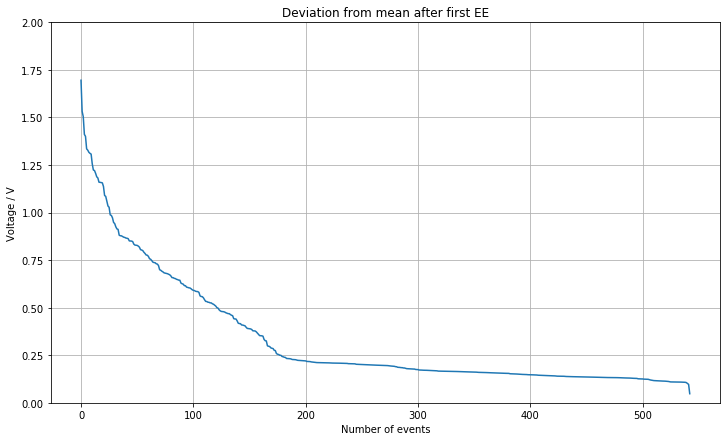

In [18]:
plt.figure(figsize=(12,7))
plt.plot(np.sort(max_deviation)[::-1])
plt.title('Deviation from mean after first EE')
plt.xlabel("Number of events")
plt.ylabel("Voltage / V")
plt.ylim((0,2))
plt.grid()

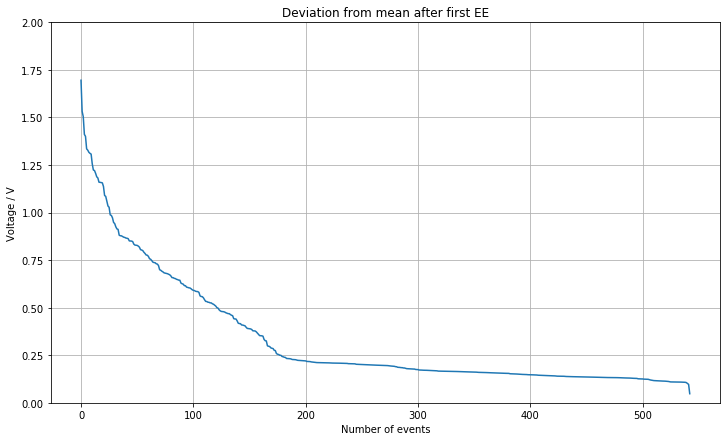

In [19]:
plt.figure(figsize=(12,7))
plt.plot(np.sort(max_deviation)[::-1])
plt.title('Deviation from mean after first EE')
plt.xlabel("Number of events")
plt.ylabel("Voltage / V")
plt.ylim((0,2))
plt.grid()

# 2D-tSNE

# look for concepts

In [ ]:
dataset = ds.train_valid_test_split(dataset=dataset)
dataset_scaled = ds.scale_dataset(dataset=dataset)

In [ ]:
dataset_scaled.loc[{'event': row['fpa_identifier']}]

In [ ]:
X_embedded = TSNE(n_components=2, init='random').fit_transform(np.nan_to_num(dataset_scaled.data.values.reshape(len(dataset_scaled.event),-1)))

In [ ]:
kmeans = KMeans(n_clusters=11, random_state=0).fit(X_embedded)
centers = kmeans.cluster_centers_

center_indices=[]

for i, center in enumerate(centers):
    distance = np.linalg.norm(X_embedded - centers[i:i + 1, :], axis=1)
    center_indices.append(np.argsort(distance)[0])

In [ ]:
plt.figure(figsize=(12,12))
plt.grid()

plt.scatter(x=X_embedded[:,0], y=X_embedded[:,1])
for i, center in enumerate(centers):
    plt.scatter(x=center[0], y=center[1], label=f"center {i}")
plt.legend()
plt.show()

In [ ]:
for i, center_indice in enumerate(center_indices):
    plt.figure()
    plt.plot(dataset[{'event': center_indice}].data.T)
    print(len(dataset[{'event': center_indice}].data.T))
    plt.title(f"center {i}")
    plt.show()